## Perguntas

1) Carregar e ler arquivos .csv, xlsx ou de um banco de dados;
2) Avaliar a necessidade da transformação da variável em outra escala (agrupar idade por faixas, por exemplo);
3) Realizar a codificação das variáveis categóricas de acordo com os valores das variáveis (label encoder, one hot encoder ou target encoder);
4) Normalizar as variáveis;
5) Avaliar a necessidade de realizar o balanceamento da variável alvo;
6) Tratar variáveis com alta correlação;
7) Realizar a seleção de variáveis;
8) Aplicar um modelo de regressão ou classificação utilizando uma técnica de hiperparametrização automática;
9) Aplicar uma medida de avaliação do modelo.
10) Gerar uma visualização para o resultado de acordo com os tipos abaixo:
    - Agrupamento: gerar a visualização Scatter;
    - Classificação: gerar a matriz de confusão; 
    - Regressão: gerar a visualização da linha de saída.

### Leitura dos dados

In [1]:
# Somente rodar se necessário
# Descomente a linha a baixo para rodar!

# %pip install googletrans==4.0.0-rc1

In [2]:
#IMPORT E INSTALL AS BIBLIOTECAS IMPORTANTES
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
from googletrans import Translator # Precisa do pacote do pip install

In [3]:
caminho = 'Data/Bike-day.csv'
df = pd.read_csv(caminho)

### Tratamento dos dados

#### Tradução 

In [4]:
def traduzir_colunas(df, language='pt'):
    #Dicionario para as palavras que não foram traduzidas ou que foram traduzidas erroneamente 
    erro_ao_traduzir = {
        'dteday': 'Data',
        'mnth': 'Mês',
        'weathersit': 'Clima',
        'temp': 'Temperatura (C°)',
        'hum': 'Umidade',
        'windspeed': 'Velocidade do Vento',
        'registered': 'Registrados',
        'cnt': 'Contador (Casual e Registrados)',
        'atemp': 'Sensação térmica'
    }
    
    # Renomear as colunas
    traducoes = {}
    tradutor = Translator()
    for coluna in df.columns:
        try:
            if coluna in erro_ao_traduzir:
                traducoes[coluna] = erro_ao_traduzir[coluna] # Utilize a tradução personalizada
            else:
                traduzido = tradutor.translate(coluna, src='en', dest=language) # Tradução acontece aqui
                if traduzido and traduzido.text:
                    capslock = traduzido.text.capitalize() # Maiúscula na primeira letra de cada palavra

                    traducoes[coluna] = capslock
                else:
                    print(f"Erro ao traduzir a coluna '{coluna}': tradução retornou None ou texto vazio")
                    traducoes[coluna] = coluna # Manter o nome original em caso de erro
        except Exception as a:
            print(f"Erro ao traduzir a coluna '{coluna}': {a}")
            traducoes[coluna] = coluna # Manter o nome original em caso de erro

    df.columns = [traducoes.get(col, col) for col in df.columns]

In [5]:
#EXECUTA A FUNÇÃO DE TRADUÇÃO
df_traduzido = df.copy()
traduzir_colunas(df_traduzido)
df_traduzido.head(5)

,Instante,Data,Temporada,Ano,Mês,Feriado,Dia da semana,Dia de trabalho,Clima,Temperatura (C°),Sensação térmica,Umidade,Velocidade do Vento,Casual,Registrados,Contador (Casual e Registrados)
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [6]:
#REMOVE O INDEXADOR DA PLANILHA
df_traduzido = df_traduzido.drop(columns=['Instante'])
df_traduzido.head(5)

,Data,Temporada,Ano,Mês,Feriado,Dia da semana,Dia de trabalho,Clima,Temperatura (C°),Sensação térmica,Umidade,Velocidade do Vento,Casual,Registrados,Contador (Casual e Registrados)
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [7]:
#RENOMEANDO OS VALORES NUMERICOS PARA ESTAÇÕES DO ANO (season : season (1:winter, 2:spring, 3:summer, 4:fall)) e Ano  (yr : year (0: 2011, 1:2012))

if 'Temporada' in df_traduzido.columns:
        df_traduzido['Temporada'] = df_traduzido['Temporada'].replace({1: 'Inverno', 2: 'Primavera', 3: 'Verão', 4: 'Outono'})

if 'Ano' in df_traduzido.columns:
        df_traduzido['Ano'] = df_traduzido['Ano'].replace({0: '2011', 1: '2012'})
df_traduzido.head(5)

,Data,Temporada,Ano,Mês,Feriado,Dia da semana,Dia de trabalho,Clima,Temperatura (C°),Sensação térmica,Umidade,Velocidade do Vento,Casual,Registrados,Contador (Casual e Registrados)
0,2011-01-01,Inverno,2011,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2011-01-02,Inverno,2011,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,2011-01-03,Inverno,2011,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,2011-01-04,Inverno,2011,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,2011-01-05,Inverno,2011,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


#### Informações gerais do dataset

In [8]:
df_traduzido.describe()

,Mês,Feriado,Dia da semana,Dia de trabalho,Clima,Temperatura (C°),Sensação térmica,Umidade,Velocidade do Vento,Casual,Registrados,Contador (Casual e Registrados)
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [9]:
df_traduzido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Data                             731 non-null    object 
 1   Temporada                        731 non-null    object 
 2   Ano                              731 non-null    object 
 3   Mês                              731 non-null    int64  
 4   Feriado                          731 non-null    int64  
 5   Dia da semana                    731 non-null    int64  
 6   Dia de trabalho                  731 non-null    int64  
 7   Clima                            731 non-null    int64  
 8   Temperatura (C°)                 731 non-null    float64
 9   Sensação térmica                 731 non-null    float64
 10  Umidade                          731 non-null    float64
 11  Velocidade do Vento              731 non-null    float64
 12  Casual                

### Análise Descritiva dos dados

Gerar tabelas sobre o data set: (gráfico de barras, colunas, linha, etc)

- relação mês x aluguel - guzinho
- relação temperatura x aluguel - guzinho

- concorrência de casual x registrado - vitinho
- Qual é o impacto dos dias úteis e feriados no uso de bicicletas? - vitinho

#### Relação season x aluguel - Allan

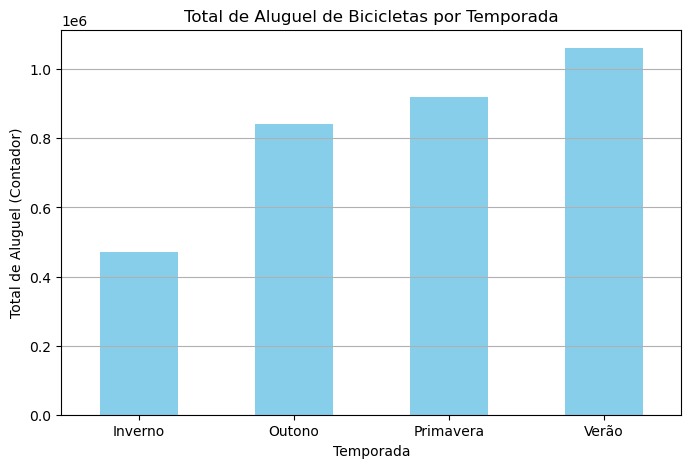

In [10]:
# Gerando o gráfico de análise descritiva
contador_temporada_X_Aluguel = df_traduzido.groupby('Temporada')['Contador (Casual e Registrados)'].sum()

plt.figure(figsize=(8, 5))
contador_temporada_X_Aluguel.plot(kind='bar', color='skyblue')
plt.title('Total de Aluguel de Bicicletas por Temporada')
plt.xlabel('Temporada')
plt.ylabel('Total de Aluguel (Contador)')
plt.xticks(rotation=0)
plt.grid(axis='y')

In [11]:
# Mostrar o gráfico
plt.show()

In [12]:
# Identificar as top temporadas com o maior número de aluguéis
top_temporadas = contador_temporada_X_Aluguel.sort_values(ascending=False).head(4)
for i, (temporada, total) in enumerate(top_temporadas.items(), start=1):
    print(f'Top {i}: {temporada} com {total} aluguéis')

Top 1: Verão com 1061129 aluguéis
Top 2: Primavera com 918589 aluguéis
Top 3: Outono com 841613 aluguéis
Top 4: Inverno com 471348 aluguéis


### Análise de correlação de variáveis - Marcelo

rodar ppscore pra ver no que da

C:\Users\Victor\AppData\Local\Temp\11\ipykernel_46264\3028576344.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True)


<Axes: >

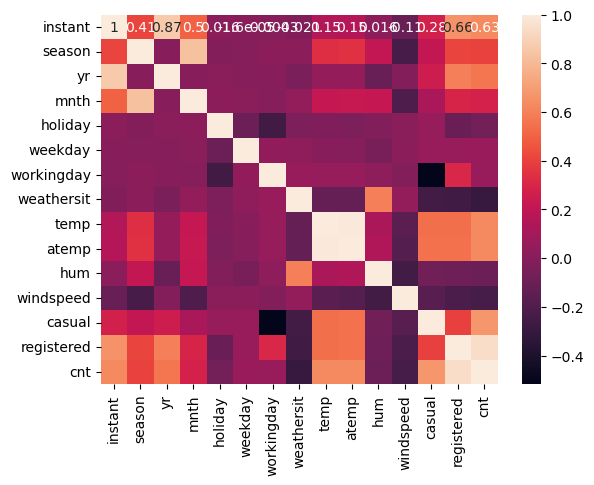

In [13]:
sns.heatmap(df.corr(), annot = True)

### Modelos de Regressão Linear

- Regressão linear - murilo
- Lasso - murilo
- Elastic Net - marcelo
- Regressão Ridge - marcelo